**Algorithmic Trading using Twitter Sentiment**
--

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime as dt
import yfinance as yf
import os

plt.style.use('ggplot')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Preprocessing**

---

	•	Converts date to a datetime object for time-based grouping.
	•	Sets a MultiIndex (date, symbol) for easier manipulation.
	•	Computes engagement_ratio as a proxy for tweet intensity/interest.
	•	Filters out tweets with low interaction to remove noise.

In [ ]:
sentiment_df = pd.read_csv('/content/drive/MyDrive/Dataset/sentiment_data.csv')

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

sentiment_df = sentiment_df.set_index(['date','symbol'])

sentiment_df['engagement_ratio'] =  sentiment_df['twitterComments']/sentiment_df['twitterLikes']

sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20)&( sentiment_df['twitterComments']>10)]

sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

**Average Engagement for each Month**







	•	Aggregates the engagement_ratio monthly for each stock.
	•	Ranks stocks within each month based on engagement to identify top performers.

In [ ]:
aggregated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'),'symbol'])[['engagement_ratio']].mean())

aggregated_df['rank'] = aggregated_df.groupby(level=0)['engagement_ratio'].transform(lambda x: x.rank(ascending=False))

aggregated_df

<ipython-input-4-dd66b041516a>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  aggregated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'),'symbol'])[['engagement_ratio']].mean())


engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

**Select top 5 stocks based on engagement**


---



	•	Selects top 5 engaged stocks per month.
	•	Adjusts the index to align with the stock price dates (moves forward 1 day to avoid forward-looking bias).

In [ ]:
 filtered_df = aggregated_df[aggregated_df['rank']<6].copy()
 filtered_df = filtered_df.reset_index(level=1)
 filtered_df.index = filtered_df.index + pd.DateOffset(days =1)
 filtered_df = filtered_df.reset_index().set_index(['date','symbol'])


**Extract the stocks to form portfolios with , at start of every month**



---



	•	Creates a dictionary mapping each date to its top stocks.
	•	This will later be used to fetch stock prices for portfolio creation.

In [ ]:
dates = filtered_df.index.get_level_values('date').unique().to_list()

fixed_dates = {}

for d in dates:

  fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d,level=0).index.to_list()


fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

**Download Fresh Stock Prices of selected Stocks**


---



	•	Downloads historical adjusted close prices for all unique stocks in the dataset.
	•	These will be used to simulate portfolio returns.

In [ ]:
stock_list = sentiment_df.index.get_level_values('symbol').unique().to_list()

prices_df = yf.download(tickers = stock_list,start='2021-01-01',end='2023-03-01')

prices_df

[*********************100%***********************]  85 of 85 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Price        Adj Close                                                         \
Ticker               A    AAL         AAP        AAPL        ABBV         ABT   
Date                                                                            
2021-01-04  115.582748  15.13  143.820755  126.544182   89.772621  101.576225   
2021-01-05  116.527771  15.43  143.665375  128.108780   90.700920  102.833008   
2021-01-06  119.723236  15.52  151.965179  123.796448   89.917412  102.618896   
2021-01-07  122.908981  15.38  153.263138  128.020782   90.879768  103.615005   
2021-01-08  123.785767  15.13  155.447815  129.125778   91.356697  103.903610   
...                ...    ...         ...         ...         ...         ...   
2023-02-22  140.083115  15.56  138.133072  147.585373  141.040497   99.153107   
2023-02-23  141.187393  15.87  136.584579  148.070984  142.351028   99.017929   
2023-02-24  139.215485  15.56  133.545303  145.404922  142.950104   96.999908   
2023-02-27  140.181686  15.63  135.257309  146.604172  144.419785   96.333672   
2023-02-28  139.974655  15.98  139.421875  146.098709  144.064056   98.216522   

Price                                                    ...   Volume  \
Ticker            AEP        AES         ALB        AMD  ...      RCL   
Date                                                     ...            
2021-01-04  70.264366  20.518082  146.840103  92.300003  ...  5732800   
2021-01-05  70.169594  21.206730  156.749374  92.769997  ...  4029500   
2021-01-06  70.729706  22.054293  168.457764  90.330002  ...  3612500   
2021-01-07  68.842552  21.833572  177.020126  95.160004  ...  3993700   
2021-01-08  68.230728  22.442755  177.116394  94.580002  ...  3104200   
...               ...        ...         ...        ...  ...      ...   
2023-02-22  84.627419  23.763327  240.590012  76.610001  ...  2044600   
2023-02-23  84.524910  23.763327  247.814072  79.750000  ...  2066600   
2023-02-24  84.263992  23.697811  243.587021  78.089996  ...  2875100   
2023-02-27  83.928551  23.285995  250.908661  78.769997  ...  2459700   
2023-02-28  81.971733  23.098816  248.263123  78.580002  ...  3662300   

Price                                                                          \
Ticker         REGN       SLB      STZ         T      TMO       TSLA      TSN   
Date                                                                            
2021-01-04   911100   8743400  1202600  86700816  2220400  145914600  2177400   
2021-01-05   797700  16256600  1530200  83054520  2046700   96735600  2297100   
2021-01-06  1434700  19456300  1861700  73455520  2112300  134100000  1942200   
2021-01-07  1126600  14502400  2537100  71265359  2144400  154496700  2969400   
2021-01-08  1018800  11951900  1595400  72471656  2221700  225166500  2672400   
...             ...       ...      ...       ...      ...        ...      ...   
2023-02-22   415500   9181100  1092200  25308800  1705300  191828500  4217700   
2023-02-23   553300   6324500   979700  24845800  1160200  146360000  3403500   
2023-02-24   525900   8458700   702900  29138100   852600  142228100  2439300   
2023-02-27   557100   6287000   608200  22981100  1110600  161028300  3922200   
2023-02-28   622700  10634200  1136900  34154800  1188800  153144900  3556300   

Price                           
Ticker             V       XOM  
Date                            
2021-01-04  10318300  27764700  
2021-01-05   6869700  44035100  
2021-01-06   7206200  36484800  
2021-01-07  10967900  29528100  
2021-01-08   6513000  28628200  
...              ...       ...  
2023-02-22   4621800  13973800  
2023-02-23   5533800  11289400  
2023-02-24   4414400  14351000  
2023-02-27   4255300  11710500  
2023-02-28   5385400  18107000  

[542 rows x 510 columns]

**Calculate returns**


---



	•	Computes logarithmic daily returns using log(P_t / P_{t-1}).
	•	Log returns are preferred for time-series modeling due to their additive properties.
	•	dropna(how='all') removes any days with no price data.

In [ ]:
returns_df = np.log(prices_df['Adj Close']).diff().dropna(how='all')

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
  end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')

  cols = fixed_dates[start_date]

  temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')

  portfolio_df = pd.concat([portfolio_df,temp_df],axis = 0)

portfolio_df



,portfolio_return
Date,
2021-12-01,-0.016417
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
...,...
2023-02-22,-0.007870
2023-02-23,-0.007323
2023-02-24,-0.009463


**Download NASDAQ prices and calculate returns**



---



	•	Downloads historical prices for QQQ, a proxy for the NASDAQ index.
	•	Computes its log returns to serve as a market benchmark.

In [ ]:
qqq_df = yf.download(tickers = 'QQQ',start='2021-01-01',end='2023-03-01')

portfolio_df['nasdaq_returns'] = np.log(qqq_df['Adj Close']).diff()

[*********************100%***********************]  1 of 1 completed


	•	Computes and plots the cumulative returns of both the Twitter-based portfolio and the NASDAQ index.
	•	Uses np.log1p() and np.exp().cumsum() to properly compound log returns.
	•	Provides a visual comparison of strategy performance over time.

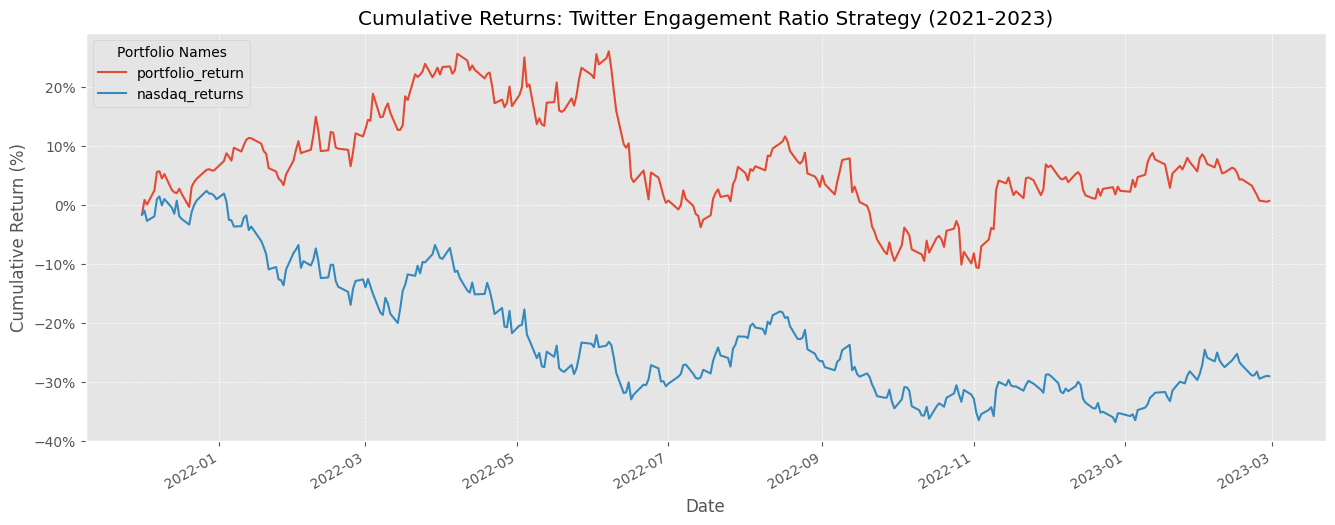

In [ ]:


# Cumulative return calculation
portfolios_cumulative_returns = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

# Plot
portfolios_cumulative_returns.plot(figsize=(16, 6))

# Title and axis formatting
plt.title('Cumulative Returns: Twitter Engagement Ratio Strategy (2021-2023)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

# Add grid and legend
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.5)
plt.legend(title='Portfolio Names', loc='upper left')

# Show the plot
plt.show()